In [48]:
## Imports
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
"""
Question 1: How many finance lending and blockchain clients does the organization have?

Process: 
    1. load industry_client_details data
    2. clean data to standardize values in industry column
    3. filter a new dataframe which has the required industry values.
    4. get count of the resultant dataframe
""" 

## Dataloading
industry_client_details_df = pd.read_csv('data/industry_client_details.csv', header=0)

## Clean industry column using regex
industry_client_details_df['industry'] = industry_client_details_df['industry'].str.replace(r'\bblock[\s\-]*chain\b', 'Block Chain', flags=re.IGNORECASE)
industry_client_details_df['industry'] = industry_client_details_df['industry'].str.replace(r'\bfinancial[\s\-]*lending\b', 'Finance Lending', flags=re.IGNORECASE)

## Filtering according to requirments
filtered_df = industry_client_details_df[(industry_client_details_df['industry'].str.contains("Block Chain")) | (industry_client_details_df['industry'].str.contains("Finance Lending"))]
count = filtered_df.shape[0]
total_count = industry_client_details_df.shape[0]
## Result output
print(f"Answer: {count} out of {total_count} clients belong to either Finance Lending or Block Chain industry")

Answer: 47 out of 100 clients belong to either Finance Lending or Block Chain industry


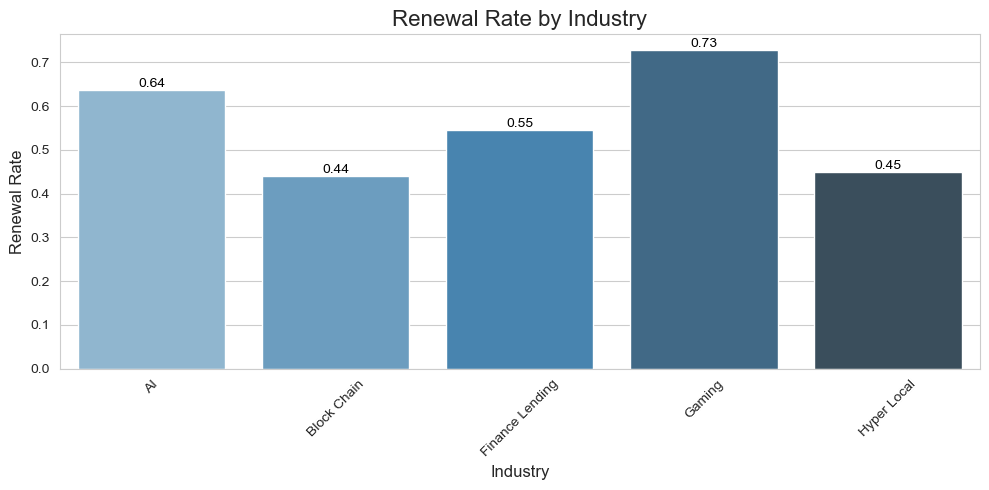

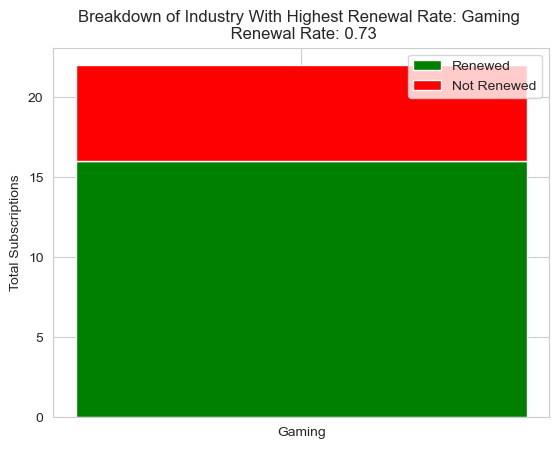

In [24]:
"""
Question 2: Which industry in the organization has the highest renewal rate?

Process: 
    1. load subscription_information data
    2. inner join industry_client_subscription_df and subscription_information_df to get renewal data for each client_id
        and the relevant industry.
    3. group data on unique industry values and calc total_subscriptions (presently) and total_renewed (for the next cycle)
    4. create a new column with renewal_rate with calc total_subscriptions and total_renewed columns to 
        calculate renewal rate per industry.
    5. get the industry with highest renewal rate and display results.
""" 

## Dataloading
subscription_information_df = pd.read_csv('data/subscription_information.csv', header=0)

## Preprocessing (inner join on industry_client_details and subscription_information with client_id as foriegn key)
industry_client_subscription_df = pd.merge(industry_client_details_df, subscription_information_df, on="client_id")

## Calculate the renewal rate for each industry
renewal_rate_df = industry_client_subscription_df.groupby('industry').agg(
    total_subscriptions=('renewed', 'count'),
    total_renewed=('renewed', 'sum')
).reset_index()

## Add new columns for renewal rate and percentage
renewal_rate_df['renewal_rate'] = renewal_rate_df['total_renewed'] / renewal_rate_df['total_subscriptions']
renewal_rate_df['renewal_percentage']=renewal_rate_df['renewal_rate']*100

## Find the industry with the highest renewal rate
highest_renewal_industry = renewal_rate_df.loc[renewal_rate_df['renewal_rate'].idxmax()]

## Display results

# Renewal rate by industry
# Set the plot style
sns.set_style("whitegrid")

# Create the bar graph
plt.figure(figsize=(10, renewal_rate_df.shape[0]))
barplot = sns.barplot(
    x='industry',
    y='renewal_rate',
    hue='industry',
    data=renewal_rate_df,
    palette="Blues_d",
    legend=False)
for bar in barplot.patches:
    height = bar.get_height()  # Get the height of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
        ha='center', va='bottom', fontsize=10, color='black'
    )
plt.title('Renewal Rate by Industry', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Renewal Rate', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# Highest renewal rate
# Create a stacked bar chart
industry = highest_renewal_industry.iloc[0]
total = highest_renewal_industry.iloc[1]
renewed = highest_renewal_industry.iloc[2]
rate = highest_renewal_industry.iloc[3]
not_renewed = total-renewed

plt.bar(industry, renewed, label='Renewed', color='green')
plt.bar(industry, not_renewed, bottom=renewed, label='Not Renewed', color='red')

plt.title(f'Breakdown of Industry With Highest Renewal Rate: {industry} \n Renewal Rate: {rate:.2f}')
plt.ylabel('Total Subscriptions')
plt.legend()
plt.show()


Average Inflation Rate: 4.44


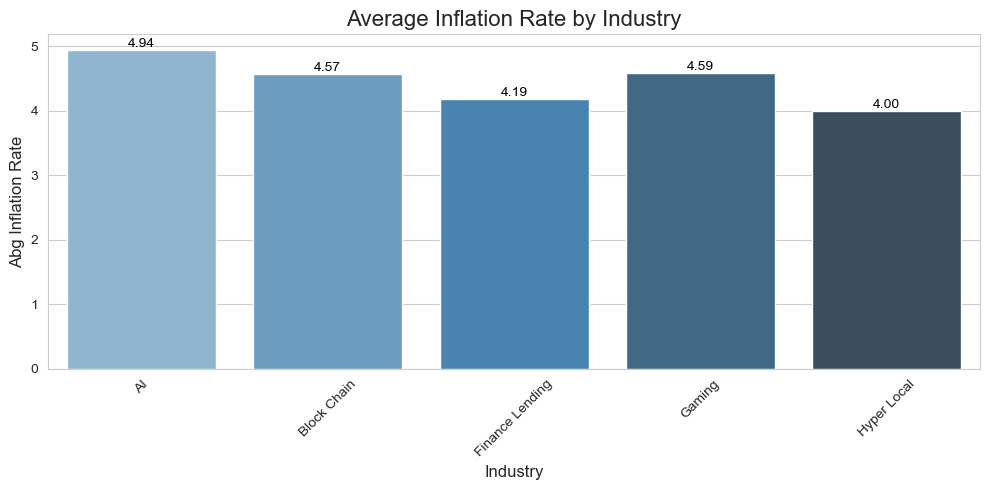

In [25]:
"""
Question 3: What was the average inflation rate when their subscriptions were renewed?

Process: 
    1. load financial_information_df data
    2. convert dates to dataframe date_time values
    3. Filter renewed subscriptions in subscription_information_df and create renewed_subscriptions
    4. cross join renewed_subscriptions and financial_information_df and filter rows where end_date from renewed_subscriptions 
        fall between data window in subscription_information_df to create renewed_with_inflation.
    5. calculate the average inflation rate

    ** if the question is asking avg inflation rate by industry
    1. inner join renewed_with_inflation with industry_client_details_df
    2. get the industry with highest renewal rate and display results.
    3. calculate avg inflation rate per industry
""" 

## Dataloading 
financial_information_df = pd.read_csv('data/finanical_information.csv', header=0)

## Convert date columns to datetime format for comparison
subscription_information_df['start_date'] = pd.to_datetime(subscription_information_df['start_date'])
subscription_information_df['end_date'] = pd.to_datetime(subscription_information_df['end_date'])
financial_information_df['start_date'] = pd.to_datetime(financial_information_df['start_date'])
financial_information_df['end_date'] = pd.to_datetime(financial_information_df['end_date'])

## Filter renewed subscriptions
renewed_subscriptions = subscription_information_df[subscription_information_df['renewed'] == True]

## Use a cross join approach to match rows from df1 to ranges in df2
## ** a vectorized approach will be faster for a larger dataset than a cross join
renewed_with_inflation = renewed_subscriptions.merge(financial_information_df, how='cross')

## Filter rows where 'end_date' falls within the 'start_date' and 'end_date' range
renewed_with_inflation = renewed_with_inflation[(renewed_with_inflation['start_date_x'] >= renewed_with_inflation['start_date_y']) & (renewed_with_inflation['start_date_x'] <= renewed_with_inflation['end_date_y'])]

## Calculate the average inflation rate
average_inflation_rate = renewed_with_inflation['inflation_rate'].mean()

## avg inflation by industry
# Calculate the avg inflation for each industry
renewed_with_inflation_and_industry = pd.merge(industry_client_details_df, renewed_with_inflation, on="client_id")

# Group by industry and store 1. total_inf_count 2. total_inf
inflation_rate_df = renewed_with_inflation_and_industry.groupby('industry').agg(
    total_inf_count=('inflation_rate', 'count'),
    total_inf=('inflation_rate', 'sum')
).reset_index()

# Add a new column for avg inflation rate
inflation_rate_df['avg_inflation_rate'] = inflation_rate_df['total_inf'] / inflation_rate_df['total_inf_count']

## Display results

print(f"\nAverage Inflation Rate: {round(average_inflation_rate,2)}")

# Renewal rate by industry
# Set the plot style
sns.set_style("whitegrid")

# Create the bar graph
plt.figure(figsize=(10, inflation_rate_df.shape[0]))
barplot = sns.barplot(
    x='industry',
    y='avg_inflation_rate',
    hue='industry',
    data=inflation_rate_df,
    palette="Blues_d",
    legend=False)

for bar in barplot.patches:
    height = bar.get_height()  # Get the height of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
        ha='center', va='bottom', fontsize=10, color='black'
    )
    
plt.title('Average Inflation Rate by Industry', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Abg Inflation Rate', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


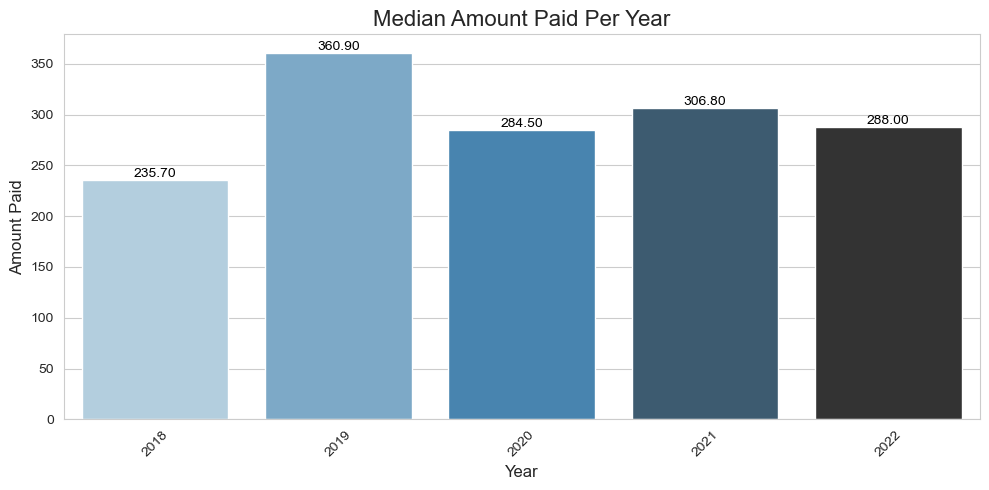

In [26]:
"""
Question 4: What is the median amount paid each year for all payment methods? 

Process: 
    1. load payment_information_df data
    2. convert dates to dataframe date_time values
    3. Extract year from payment_date
    4. Get results by Grouping by year and calculating the median of amount_paid

""" 

# Dataloading
payment_information_df = pd.read_csv('data/payment_information.csv', header=0)

# Convert payment_date to datetime format
payment_information_df['payment_date'] = pd.to_datetime(payment_information_df['payment_date'])

# Extract year from payment_date
payment_information_df['year'] = payment_information_df['payment_date'].dt.year

# Group by year and calculate the median of amount_paid
median_paid_per_year = payment_information_df.groupby('year')['amount_paid'].median().reset_index()

## Display results
# Set the plot style
sns.set_style("whitegrid")

# Create the bar graph
plt.figure(figsize=(10, median_paid_per_year.shape[0]))
barplot = sns.barplot(
    x='year',
    y='amount_paid',
    hue='year',
    data=median_paid_per_year,
    palette="Blues_d",
    legend=False)
for bar in barplot.patches:
    height = bar.get_height()  # Get the height of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
        ha='center', va='bottom', fontsize=10, color='black'
    )
plt.title('Median Amount Paid Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Amount Paid', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()
